<a href="https://colab.research.google.com/github/rodrigoclira/mineracao-dados/blob/main/shap_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn import (
    model_selection,
    preprocessing,
)
b = load_boston()
bos_X = pd.DataFrame(
    b.data, columns=b.feature_names
)
bos_y = b.target
bos_X_train, bos_X_test, bos_y_train, bos_y_test = model_selection.train_test_split(
    bos_X,
    bos_y,
    test_size=0.3,
    random_state=42,
)
bos_sX = preprocessing.StandardScaler().fit_transform(
    bos_X
)
bos_sX_train, bos_sX_test, bos_sy_train, bos_sy_test = model_selection.train_test_split(
    bos_sX,
    bos_y,
    test_size=0.3,
    random_state=42,
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [2]:
import xgboost as xgb
xgr = xgb.XGBRegressor(
    random_state=42, base_score=0.5
)
xgr.fit(bos_X_train, bos_y_train)

[03:27:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [3]:
sample_idx = 5
xgr.predict(bos_X.iloc[[sample_idx]])

array([27.269186], dtype=float32)

In [5]:
!pip install shap

     |████████████████████████████████| 564 kB 5.0 MB/s 


Para usar o modelo, temos de criar um TreeExplainer a partir de nosso modelo e
estimar os valores SHAP para nossas amostras. Se quisermos usar o Jupyter e
ter uma interface interativa, também será necessário chamar a função initjs:

In [6]:
import shap
shap.initjs()
exp = shap.TreeExplainer(xgr)
vals = exp.shap_values(bos_X)

Com o explainer e os valores SHAP, podemos criar um gráfico de forças
(force plot) para explicar a predição (veja a Figura 16.1). Esse gráfico
informa que a previsão de base é 23, e que o status da população (LSTAT) e
a taxa de impostos da propriedade (TAX) empurram o preço para cima,
enquanto o número de cômodos (RM) empurra o preço para baixo:

In [8]:
shap.initjs()
shap.force_plot(
    exp.expected_value,
    vals[sample_idx],
    bos_X.iloc[sample_idx],
)

Podemos visualizar o gráfico de forças para todas as amostras, bem como ter
uma noção geral do comportamento. Se estivermos usando o modo
JavaScript interativo no Jupyter, é possível passar o mouse sobre as amostras
e ver quais atributos estão causando impacto no resultado

In [9]:
shap.initjs()
shap.force_plot(
    exp.expected_value, vals, bos_X
)

A partir do gráfico de forças da amostra, vimos que o atributo LSTAT causa
um grande impacto. Para visualizar como LSTAT afeta o resultado, podemos
criar um gráfico de dependências. A biblioteca escolherá automaticamente
um atributo para colorir de acordo com ele (você pode fornecer o parâmetro
interaction_index para definir o seu próprio atributo).

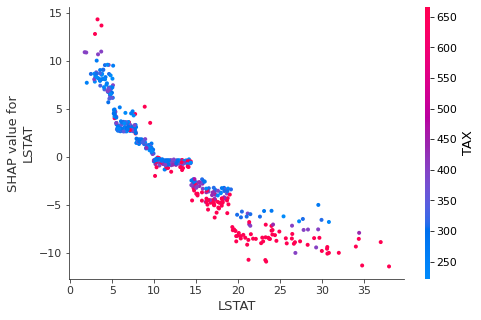

In [12]:
shap.initjs()
#fig, ax = plt.subplots(figsize=(6, 4))
shap.dependence_plot("LSTAT", vals, bos_X)
# fig.savefig(
#     "images/mlpr_1603.png",
#     bbox_inches="tight",
#     dpi=300,
# )

A seguir, apresentamos outro gráfico de dependência, exibido na Figura 16.4,
para explorar o atributo DIS (distância até os centros de empregos). Parece
que esse atributo tem pouco efeito, a menos que tenha valores bem baixos:

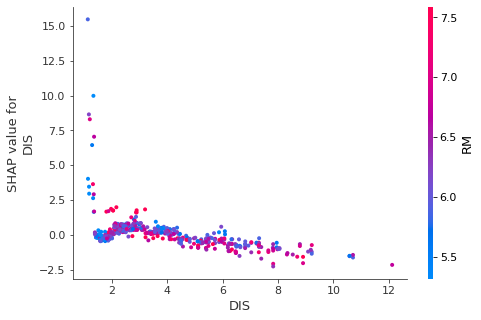

In [14]:
#fig, ax = plt.subplots(figsize=(6, 4))
shap.dependence_plot(
    "DIS", vals, bos_X, interaction_index="RM"
)
# fig.savefig(
#     "images/mlpr_1604.png",
#     bbox_inches="tight",
#     dpi=300,
# )

Por fim, veremos o efeito global dos atributos usando um gráfico de resumo. Os atributos na parte superior causam mais impacto no modelo. A partir
dessa visualização, podemos notar que valores maiores de RM (número de
cômodos) empurram bastante o valor do alvo para cima, enquanto valores
medianos e menores empurram o valor um pouco para baixo:

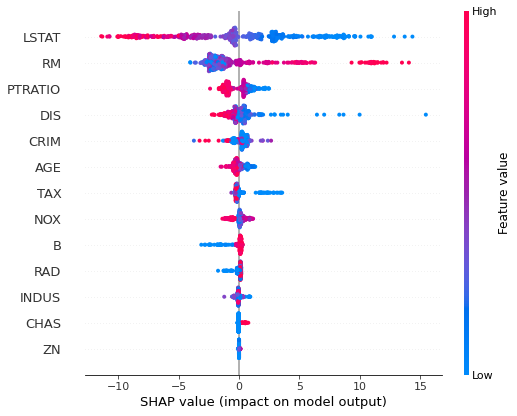

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
shap.summary_plot(vals, bos_X)
# fig.savefig(
#     "images/mlpr_1605.png",
#     bbox_inches="tight",
#     dpi=300,
# )